# Image Processing

## OpenCV URL ⇨ [Segmentation](https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html)

In [1]:
# 2回目以降，このセルを実行しないように
import os 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# おまじない
%load_ext autoreload
%autoreload 2
%matplotlib inline
os.getcwd()

# file = "sample_name" + "_" + "img_name"
file = ["Sample1_6047", "Sample2_6051", "Sample3_6055", "Sample3_6054", "Sample4_6058", "Sample5_6061", "Sample6_6064",
        "Sample7_6068", "Sample8_6073", "Sample9_6077", "Sample10_6081", "Sample11_6085"]

# data frame
df_dis = pd.DataFrame()
df_dis_t = pd.DataFrame()

In [2]:
# file number
filenum = 0
filename = file[filenum]

# sample name
sample_name = filename.split("_")[0]
img_name = "IMG_{}".format(filename.split("_")[1])
print(sample_name, img_name)

Sample1 IMG_6047


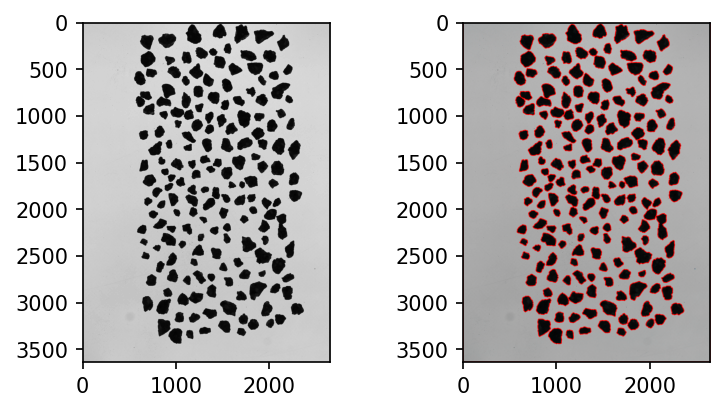

In [3]:
# image name
name = img_name

# gray image
img = cv2.imread("2020-11/{}.jpg".format(name))
img = img[630:4272, 0:2648]
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Otsu binary
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=5)

# Finding sure foreground area
thr = 0.2
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, thr*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
# Now, mark the region of unknown with zero
markers = markers+1
markers[unknown==255] = 0

markers = cv2.watershed(img, markers)

# Apply Watershed
# contours(輪郭), hierarchy(階層，親子)
contours, hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        # draw contours  (255, 0,　0)： color red,  5pt line
        cv2.drawContours(img, contours, i, (255, 0, 0), 5)


# plot
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)

ax[0].imshow(gray, cmap="gray") 
ax[1].imshow(img)

In [4]:
# delete outlier
contours = np.delete(contours, -2,0)
contours = np.delete(contours, -1,0)

In [12]:
from math import sqrt, pi, cos, sin
from tqdm import tqdm
from scipy.spatial import distance

# shape parameters
Areas = []
Perimeters = []
Circularities = []
Eq_diameters = []
Longest = []
Shortest = []
Aspect_Ratio = []
Distance_Gomez_test = []
degrees = np.arange(0, 2*pi, 2*pi/360) # degrees: 2pi/360 = 1degree

for cnt in tqdm(contours):
    # Area 
    area = cv2.contourArea(cnt)
    Areas.append(area)
    
    # perimeter
    arc = cv2.arcLength(cnt, True)
    Perimeters.append(arc)
    
    # circularity
    circularity = 4 * np.pi * area/(arc*arc)
    Circularities.append(circularity)
    
    # Equaldiameter
    eq_diameter = np.sqrt(4 * area/np.pi)
    Eq_diameters.append(eq_diameter)
    
    # Ellipse - shortest longest length
    ellipse = cv2.fitEllipse(cnt)
    Shortest.append(ellipse[1][0])
    Longest.append(ellipse[1][1])
    
    # Aspect Ratio
    Aspect_Ratio.append(ellipse[1][0]/ellipse[1][1])
    
    # Moment
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # Distance (contour signals)
    for deg in degrees:
        for cnts in cnt:
            # cnts (x,y)
            x = cnts[0,0]
            y = cnts[0,1]
            # euclidean distance (moment ~ cnt)
            d_eu = distance.euclidean((x,y), (cx,cy))
            if abs(cos(deg)-(x-cx)/d_eu) < 0.2 and abs(sin(deg)-(y-cy)/d_eu) < 0.2:
                break
            else:
                continue
        # Scaling
        d_eu_scaled = d_eu/eq_diameter
        Distance_Gomez_test.append(d_eu_scaled)
    
    
            
        

100%|██████████| 351/351 [04:10<00:00,  1.40it/s]


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


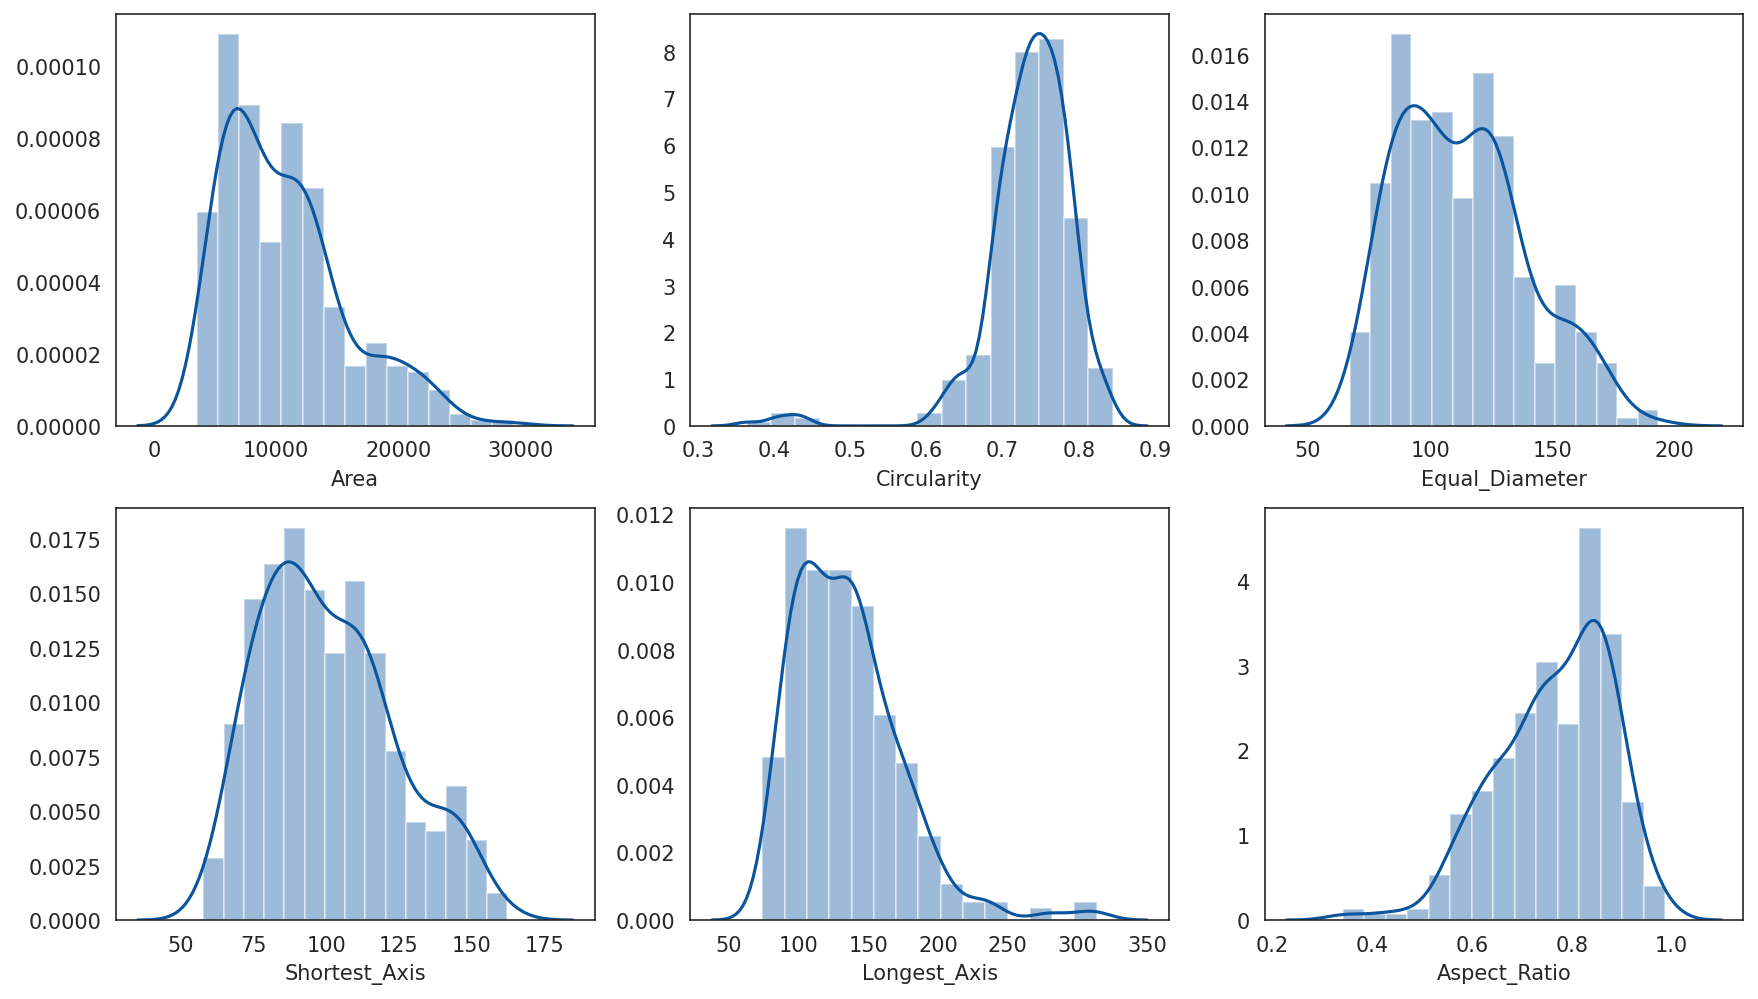

In [13]:
# sample names
names = []
len(Areas)
for i in range(len(Areas)):
    names.append(name)

# dataframe
import pandas as pd
df = pd.DataFrame({'Area': Areas, 'Circularity': Circularities, 'Equal_Diameter': Eq_diameters, 'Shortest_Axis': Shortest, 'Longest_Axis': Longest,
                   'Perimeters': Perimeters, 'Aspect_Ratio': Aspect_Ratio, 'name': names})
import seaborn as sns
sns.set_style('white')
sns.set_palette('Blues_r')

fig, ax = plt.subplots(2,3,figsize=(14,8), dpi=150)

sns.distplot(df['Area'], ax=ax[0,0], bins=15)
sns.distplot(df['Circularity'], ax=ax[0,1], bins=15)
sns.distplot(df['Equal_Diameter'], ax=ax[0,2], bins=15)
sns.distplot(df['Shortest_Axis'], ax=ax[1,0], bins=15)
sns.distplot(df['Longest_Axis'], ax=ax[1,1], bins=15)
sns.distplot(df['Aspect_Ratio'], ax=ax[1,2], bins=15);

# save dataset as "csv"
# 'w': 新規作成・上書き保存， 'a': 追記，
pd.DataFrame.to_csv(df, 'csv/{}.csv'.format(name), index=False, mode = 'w')

In [14]:
cnt_n = np.arange(0,300,3)

1
n = 1.0


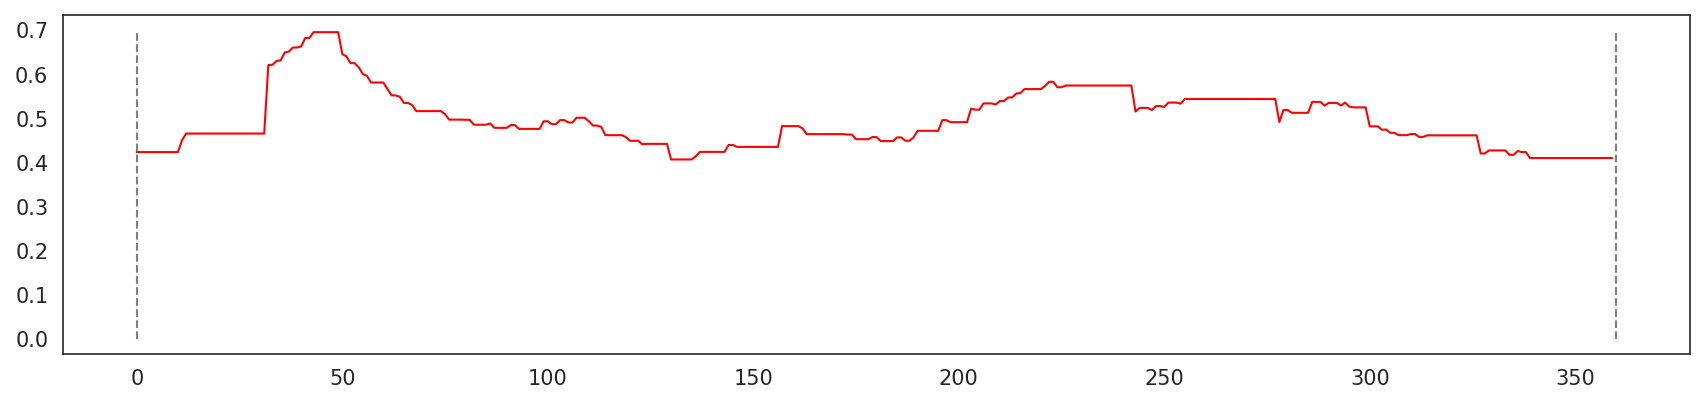

In [15]:
# plot countour signal
rad = 360
n=1
print(n)
print(f'n = {len(Distance_Gomez_test[:rad*n])/rad}')
plt.figure(figsize=(14,3), dpi=150)
plt.plot(np.arange(len(Distance_Gomez_test[:rad*n])), Distance_Gomez_test[:rad*n], c='r', lw=1)
# vline
vline = np.arange(0, rad+1, rad)
for i in vline:
    plt.vlines([i], 0, 0.7, 'gray', linestyle='dashed', lw=1)

30
n = 30.0


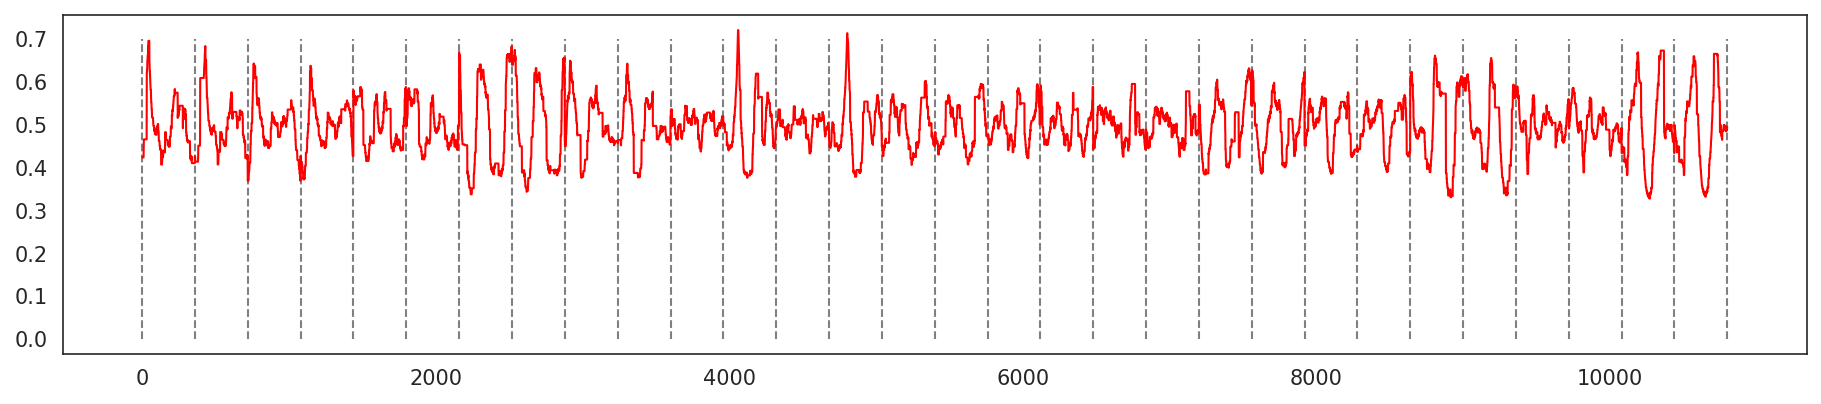

In [17]:
# plot contour signal
rad = 360
n = 30
print(n)
print(f'n = {len(Distance_Gomez_test[:rad*n])/rad}')

# plot
plt.figure(figsize=(15,3), dpi=150)
plt.plot(np.arange(len(Distance_Gomez_test[:rad*n])), Distance_Gomez_test[:rad*n], c='r', lw=1)
# vline
vline = np.arange(0, (rad*n)+1, rad)
for i in vline:
    plt.vlines([i], 0, 0.7, 'gray', linestyle='dashed', lw=1)

In [30]:
# save distance to csv file name = "Sample_test"
df_dis_t["{}".format(sample_name)] = Distance_Gomez_test
pd.DataFrame.to_csv(df_dis_t, 'csv/diS1.csv', index=False, mode = 'w')